# Triangle Meshes

This notebook demonstrates the application of `circle_bundles` to a synthetic dataset of 3D densities constructed from ...


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import circle_bundles as cb


First, generate a dataset of triangle meshes, stored as vectors of length $3\times 6 = 18$:

In [3]:
#Create the template triangle mesh
mesh = cb.make_star_pyramid(n_points = 5, height = 1)

#Create a visualization function
vis_func = cb.make_star_pyramid_visualizer(mesh)

n_samples = 5000
rng = np.random.default_rng(0)
so3_data = cb.sample_so3(n_samples, rng=rng)[0]

data = cb.get_mesh_sample(mesh, so3_data)

View a small sample of the dataset:

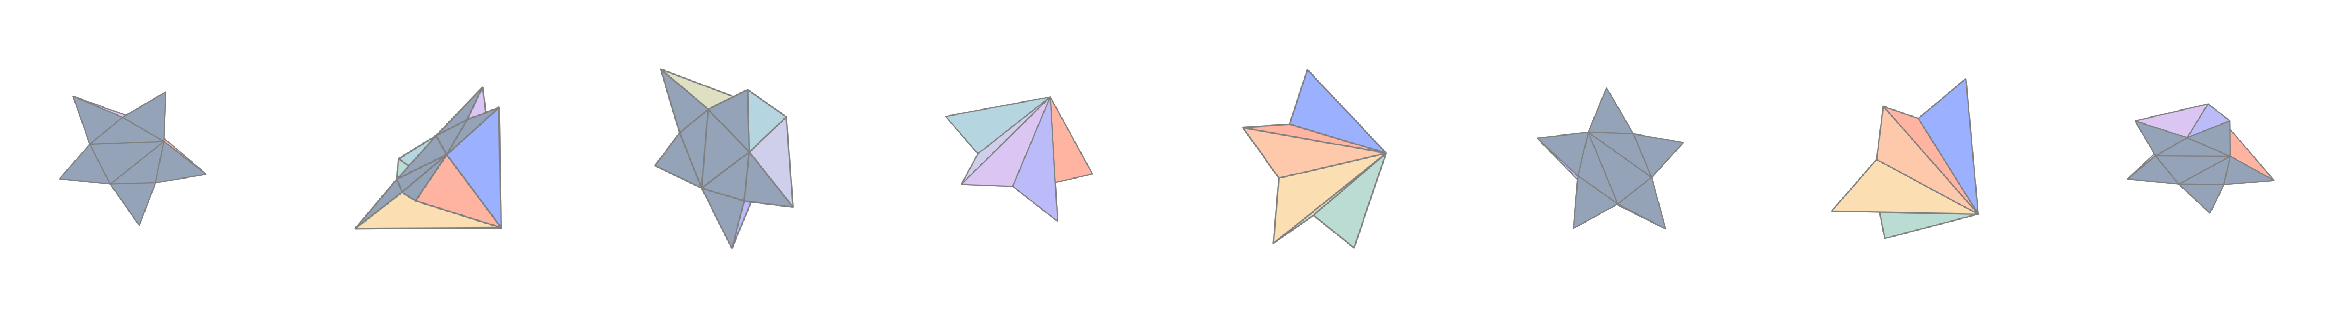

In [5]:
fig = cb.show_data_vis(
    data, 
    vis_func, 
    max_samples=8, 
    n_cols=8, 
    sampling_method="first", 
    pad_frac=0.3)
plt.show()


Compute the base projections to $\mathbb{S}^{2}$:

In [6]:
base_points = cb.mesh_vertex_normals(data)

Construct an open cover of $\mathbb{S}^{2}$ using a collection of nearly equidistant landmark points (see reference section):

### Cover And Nerve Summary
- $n_\text{sets} = 60$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 60$
- $\#(\text{1-simplices}) = 174$
- $\#(\text{2-simplices}) = 116$
- *No recorded simplices in dimensions* $\ge 3$

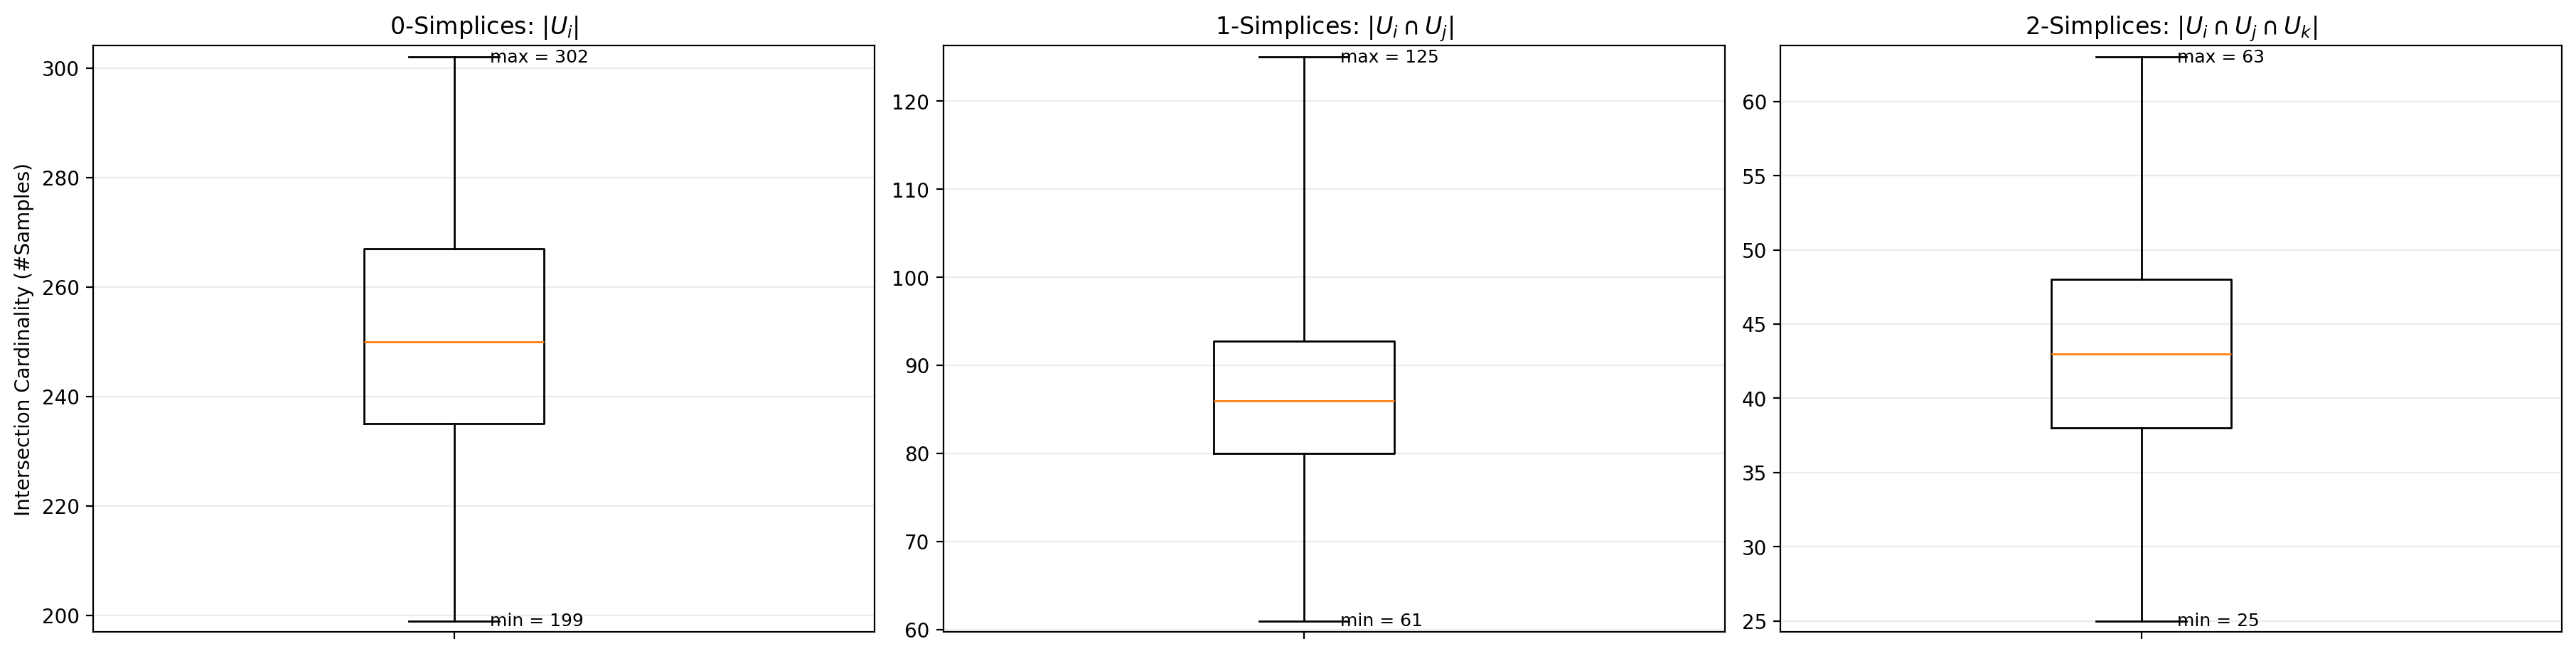

In [7]:
n_landmarks = 60
cover = cb.make_s2_fibonacci_star_cover(base_points, n_vertices = n_landmarks)

summ = cover.summarize(plot = True)

Optionally run the cell below to view a Plotly visualization of the nerve of the open cover:

In [ ]:
fig = cover.show_nerve()

Compute a persistence diagram for the data in each set $\pi^{-1}(U_{j})$

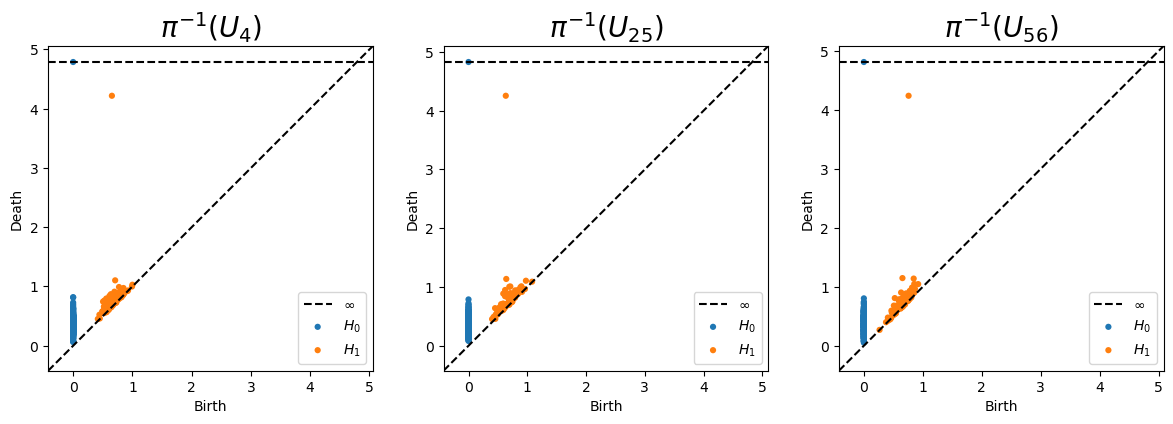

In [8]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    to_view = [4,25,56], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Optionally run the cell below to show a visualization of an interactive visualization of the projection map:

In [9]:
app = cb.show_bundle_vis(base_points = base_points, data = data)

Bundle viewer running at: http://127.0.0.1:52828/


Compute local circular coordinates, approximate transition matrices and characteristic clases

In [10]:
bundle = cb.build_bundle(
    data,
    cover,
    show=True,                          
)

<IPython.core.display.Math object>

Now, restrict the bundle to the equator $\mathbb{S}^{1}\subset \mathbb{S}^{2}$:

In [11]:
eps = 0.15  # thickness of equatorial band (in the chosen S^2 embedding/coords)

# Points near the equator: last coordinate close to 0
eq_mask = np.abs(base_points[:, -1]) < eps

eq_data = bundle.data[eq_mask]

# Parametrize the equator by an angle in S^1 
eq_base_angles = np.arctan2(base_points[eq_mask, 1], base_points[eq_mask, 0]) % (2*np.pi)

print(f"Equator band: {eq_data.shape[0]} / {bundle.data.shape[0]} samples (eps={eps}).")

Equator band: 698 / 5000 samples (eps=0.15).


Constuct an open cover of $\mathbb{S}^{1}$ by metric balls around equally-spaced landmark points:

### Cover And Nerve Summary
- $n_\text{sets} = 12$, $n_\text{samples} = 698$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 12$
- $\#(\text{1-simplices}) = 12$
- *No recorded simplices in dimensions* $\ge 2$

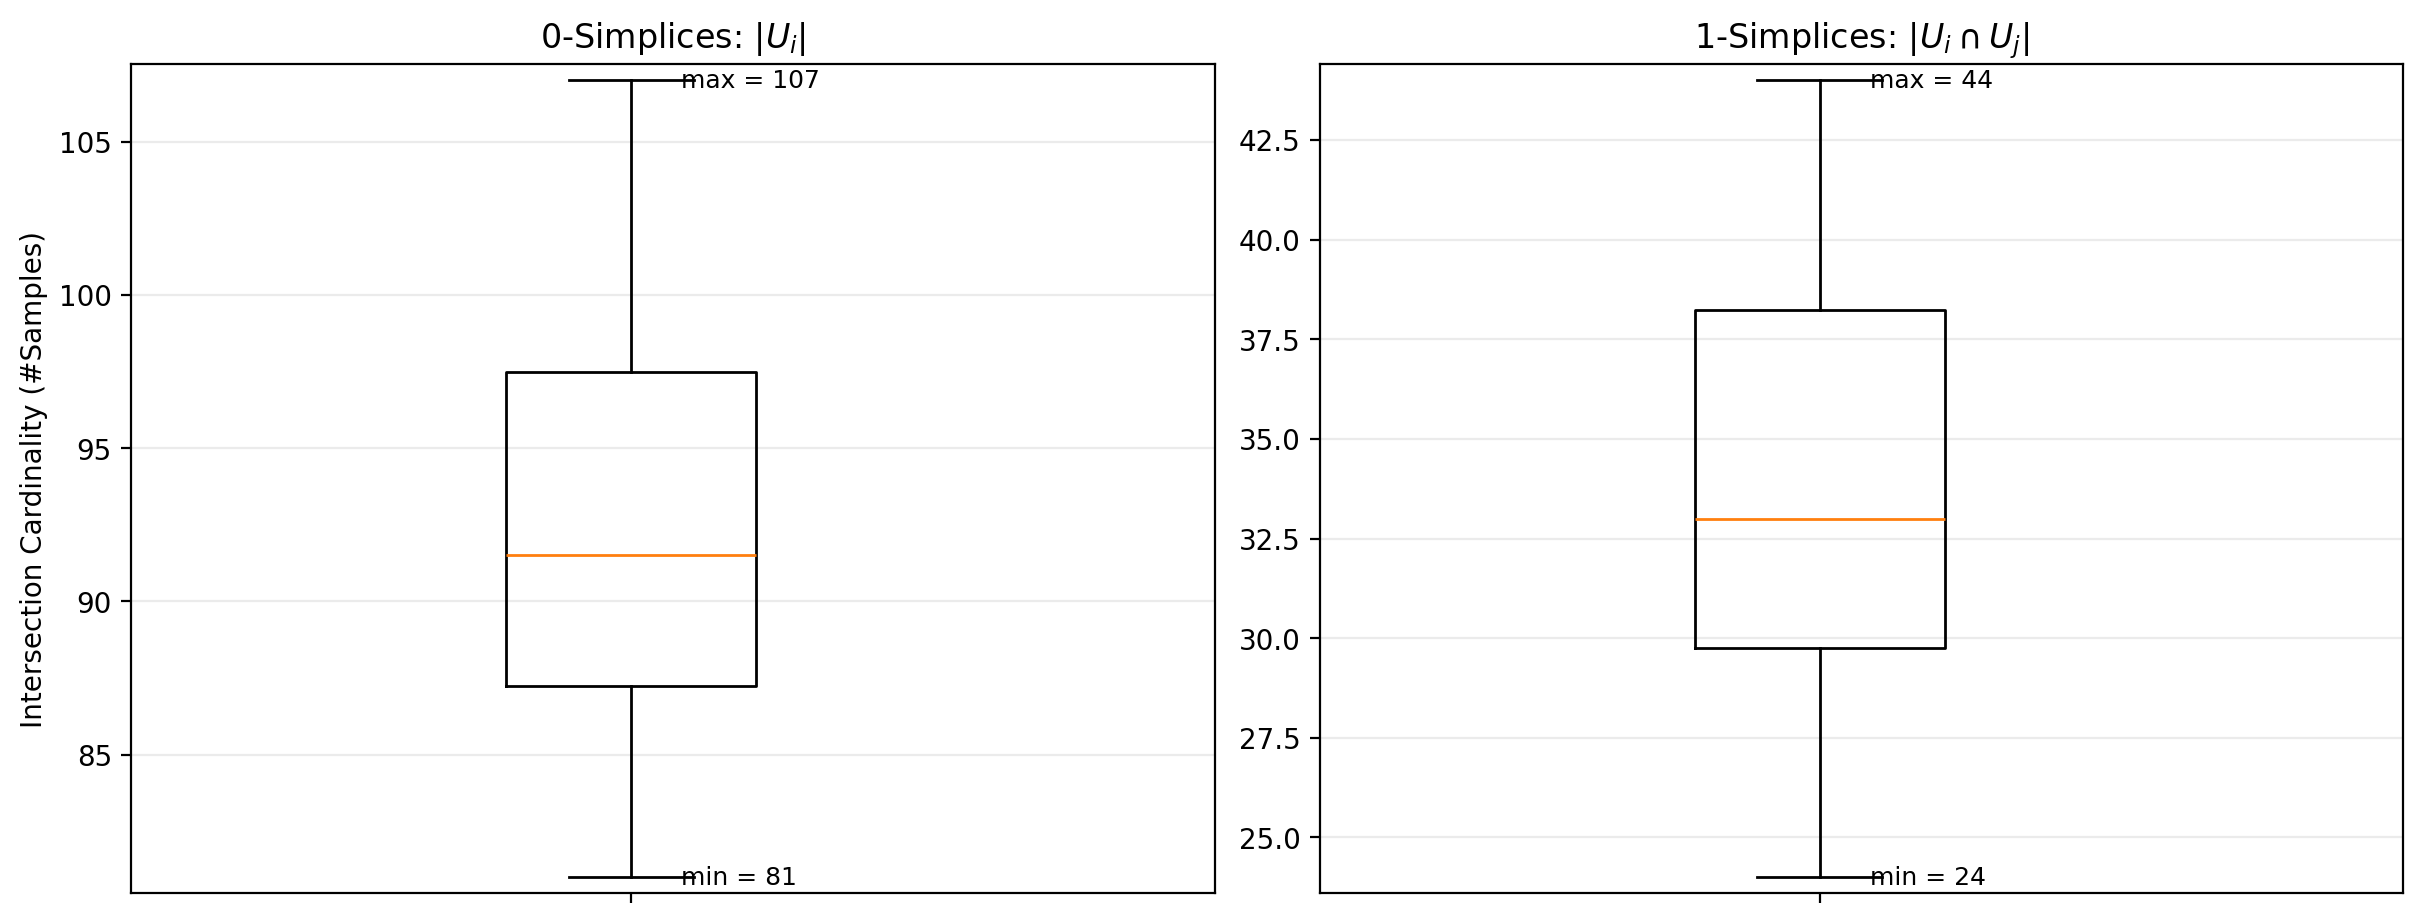

In [23]:
n_landmarks = 12
landmarks = np.linspace(0, 2*np.pi, n_landmarks, endpoint=False)

overlap = 1.6
radius = overlap * np.pi / n_landmarks

eq_cover = cb.MetricBallCover(
    eq_base_angles,
    landmarks,
    radius,
    metric=cb.S1AngleMetric(),
)
eq_cover_data = eq_cover.build()

#Show a summary of the construction
eq_summ = eq_cover.summarize(plot = True)

Compute characteristic classes for the restricted bundle:

In [24]:
eq_bundle = cb.build_bundle(
    eq_data,
    eq_cover,
    show=True,
)


<IPython.core.display.Math object>

Observe that the restricted bundle is orientable, hence trivial, as expected. Construct a global toroidal coordinate system by synchronizing local circular coordinates:

In [25]:
eq_triv_result = eq_bundle.get_global_trivialization()

Finally, show a visualization of the coordinatized meshes:

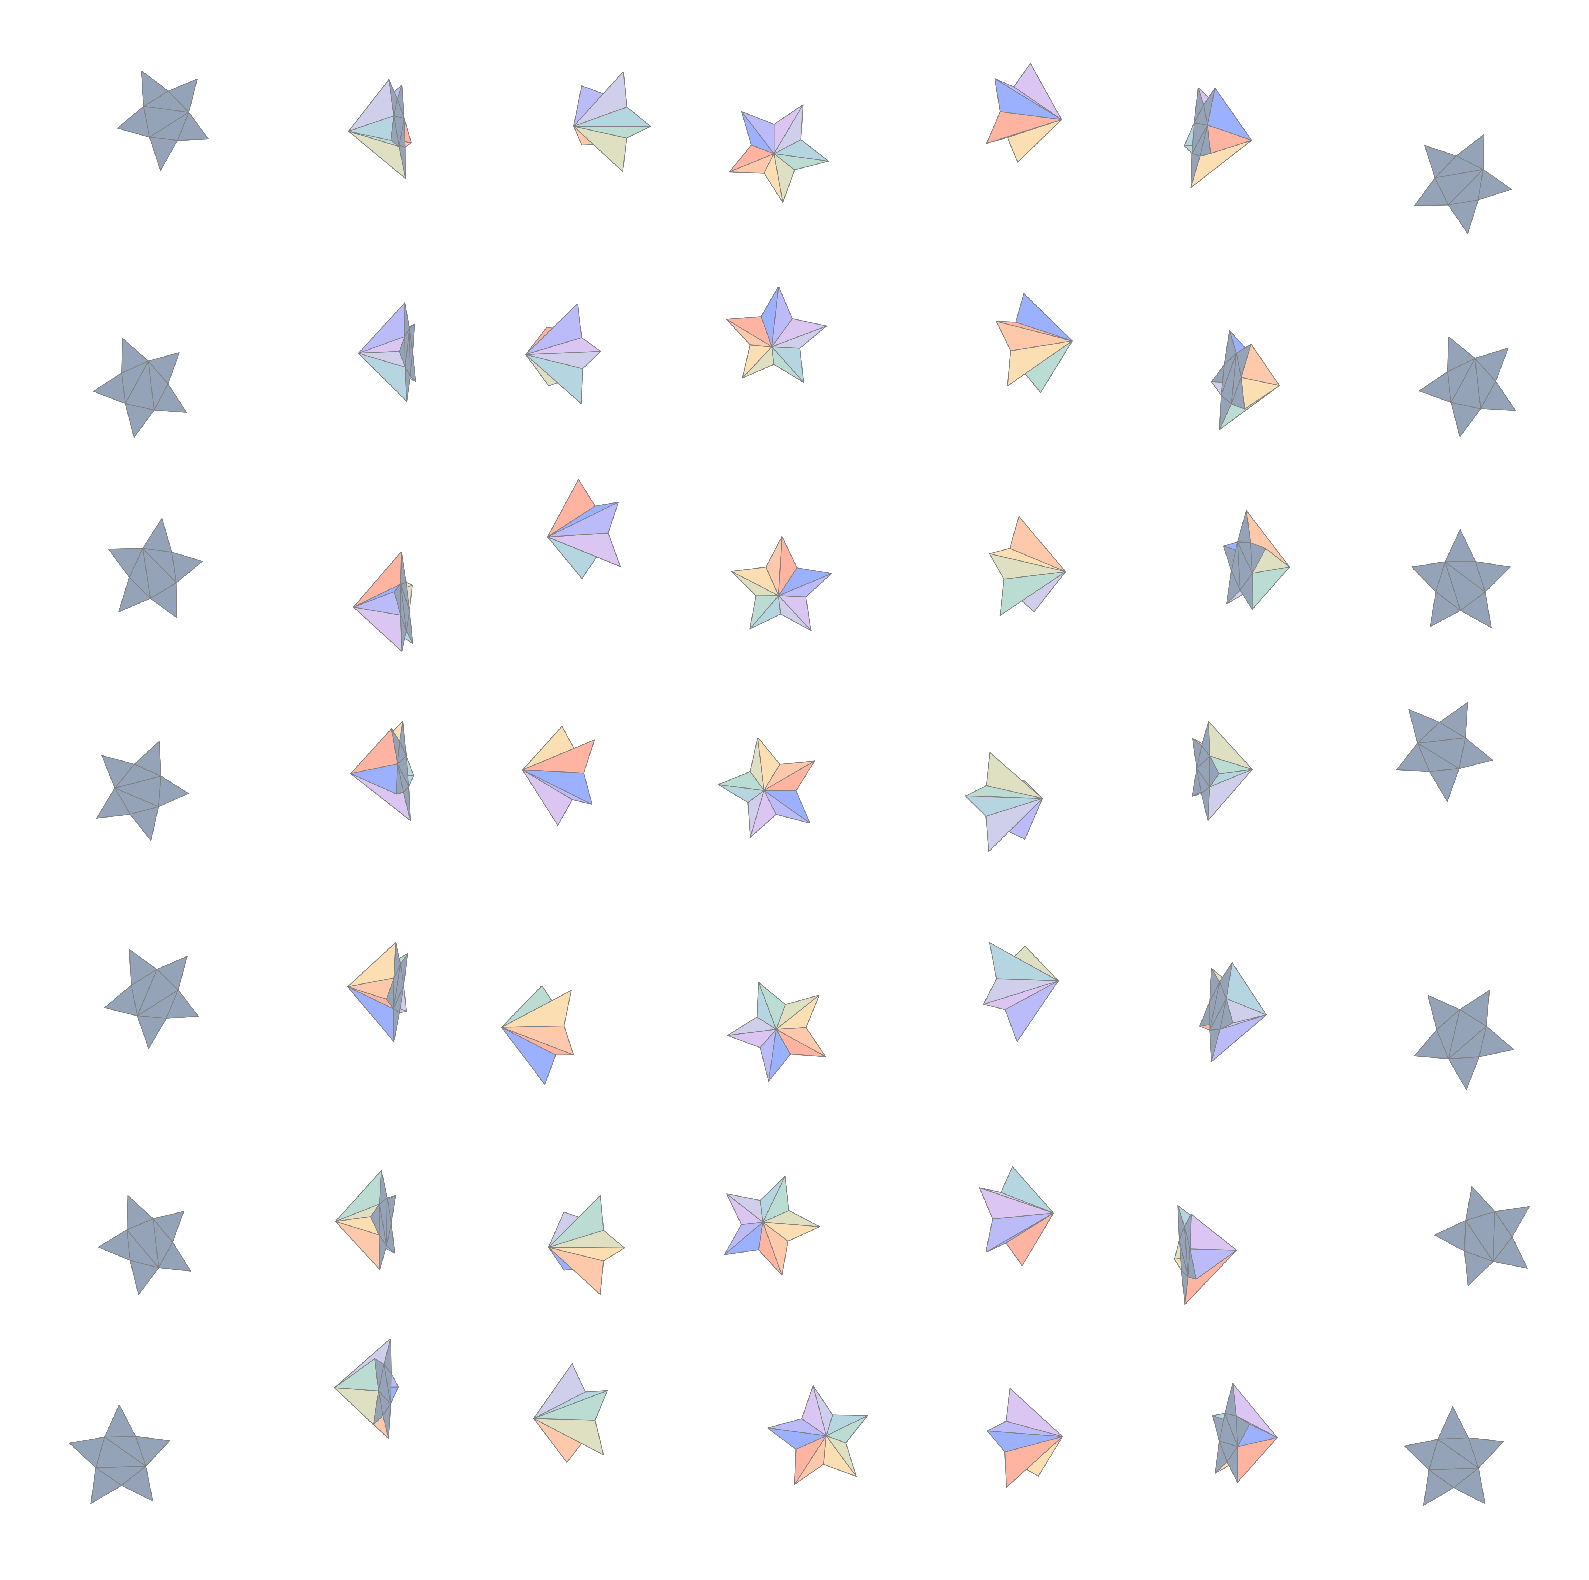

In [26]:
coords = np.column_stack([eq_base_angles, eq_triv_result.F])

fig = cb.lattice_vis(
    eq_data,
    coords,
    vis_func,
    per_row=7,
    per_col=7,
    figsize=10,
    thumb_px=100,
    dpi=200,
)

plt.show()


Base projection angle varies from $0$ to $2\pi$ along the $x$-direction and fiber angle varies from $0$ to $2\pi$ along the $y$-direction.  Notice that base projection roughly corresponds to axis of symmetry, as expected.  The coordinatized meshes in each column approximately traverse a full rotation about the axis of symmetry. Meshes on opposite edges of the diagram roughly correspond, reflecting the toroidal topology of the restricted dataset. 